In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [47]:
data_dir = 'breast-cancer-data'

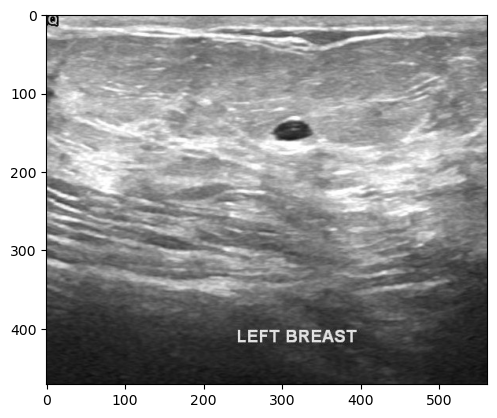

In [48]:
import matplotlib.image as mping
test_image = "breast-cancer-data/benign/benign (1).png"
img = mping.imread(test_image)
plt.imshow(img)

In [49]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [50]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed=132,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 1578 files belonging to 6 classes.
Using 1263 files for training.


In [51]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=132,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 1578 files belonging to 6 classes.
Using 315 files for validation.


In [52]:
class_names = train_ds.class_names
class_names

['benign',
 'benign mask',
 'malignant',
 'malignant mask',
 'normal',
 'normal mask']

In [54]:
# extra code to save the figures as high-res PNGs for the book
from pathlib import Path

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

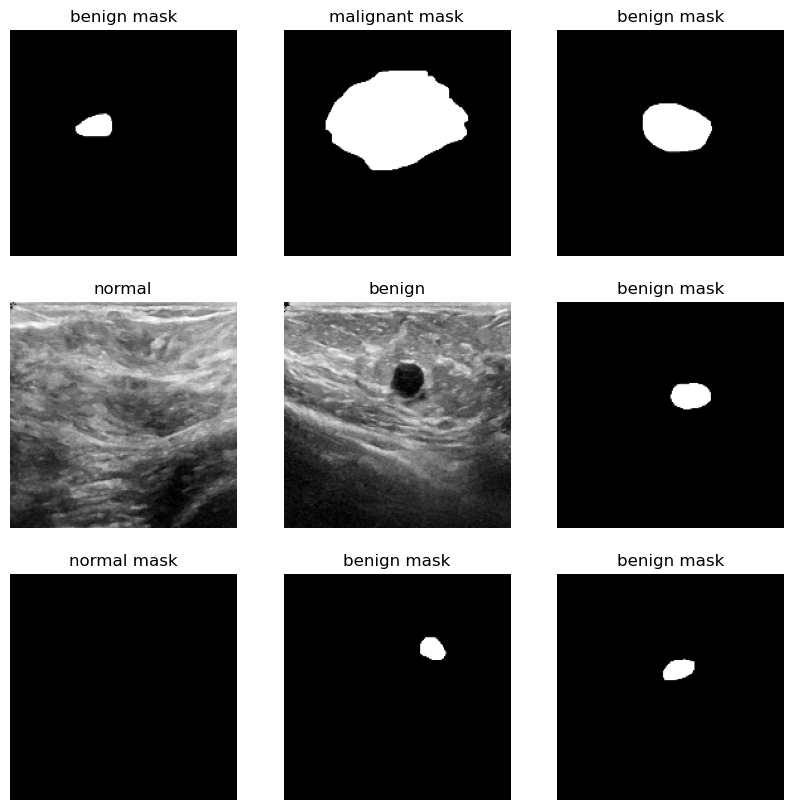

In [53]:
# Here are the first nine images from my training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range (9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [10]:
# manually iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [11]:
# configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# Standadrize the values in the [0,1] RGB channel range by using tf.keras.Rescaling
normailization_layers = layers.Rescaling(1./255)

In [13]:
# create a keras model
num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16,3, padding='same', activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same',  activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [14]:
# compile the model
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
# train the model for 10 epochs
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
40/40 [==============================] - 119s 2s/step - loss: 0.9109 - accuracy: 0.5899 - val_loss: 0.7620 - val_accuracy: 0.6730
Epoch 2/10
40/40 [==============================] - 56s 1s/step - loss: 0.6437 - accuracy: 0.7221 - val_loss: 0.8015 - val_accuracy: 0.6730
Epoch 3/10
40/40 [==============================] - 53s 1s/step - loss: 0.4690 - accuracy: 0.8116 - val_loss: 0.7307 - val_accuracy: 0.7492
Epoch 4/10
40/40 [==============================] - 53s 1s/step - loss: 0.3537 - accuracy: 0.8638 - val_loss: 0.8655 - val_accuracy: 0.7333
Epoch 5/10
40/40 [==============================] - 52s 1s/step - loss: 0.2302 - accuracy: 0.9192 - val_loss: 1.0131 - val_accuracy: 0.7810
Epoch 6/10
40/40 [==============================] - 56s 1s/step - loss: 0.1366 - accuracy: 0.9604 - val_loss: 1.2312 - val_accuracy: 0.7683
Epoch 7/10
40/40 [==============================] - 61s 2s/step - loss: 0.1014 - accuracy: 0.9644 - val_loss: 1.3418 - val_accuracy: 0.7556
Epoch 8/10
40/40 [=

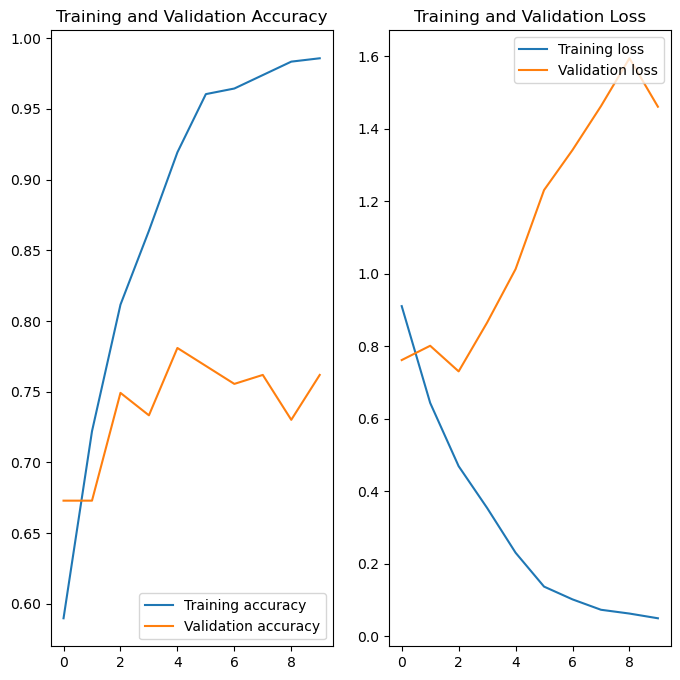

In [17]:
# visualize training rsults by ploting plots for accuracy and loss on thr training and validation sets

acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [18]:
# reduce overfitting through data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

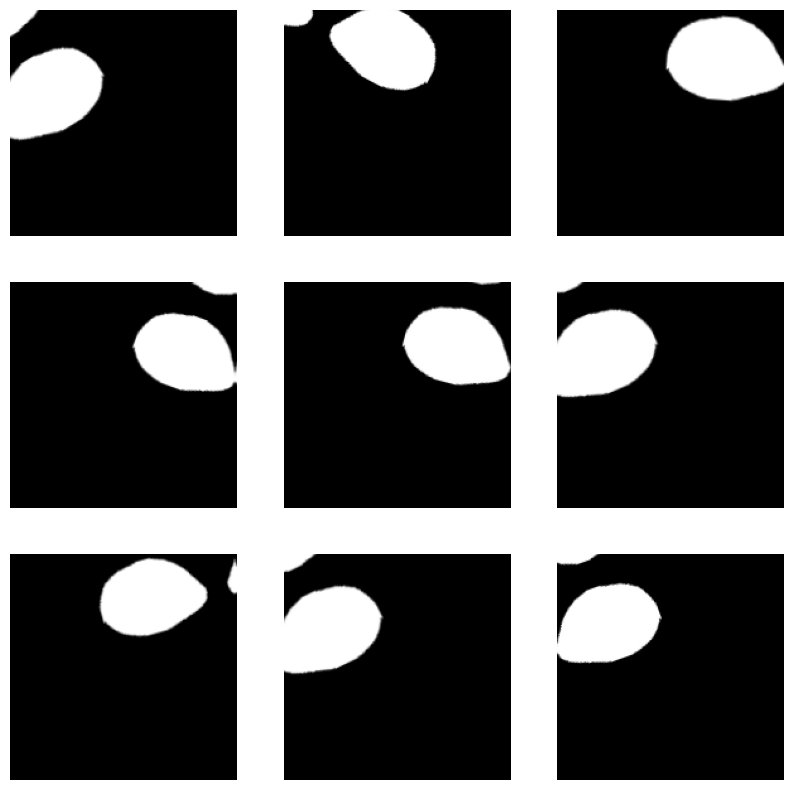

In [19]:
# visualize a few augmented examples by applying data augmentation to the same image several times
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [20]:
# intoduce Dropout in the network to help reduce overfitting further

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, name="outputs")
])

In [21]:
# compile and train the model
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [23]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
40/40 [==============================] - 75s 1s/step - loss: 0.9542 - accuracy: 0.5685 - val_loss: 0.7654 - val_accuracy: 0.6444
Epoch 2/15
40/40 [==============================] - 60s 2s/step - loss: 0.7321 - accuracy: 0.6809 - val_loss: 0.7285 - val_accuracy: 0.6667
Epoch 3/15
40/40 [==============================] - 70s 2s/step - loss: 0.7014 - accuracy: 0.6809 - val_loss: 0.7216 - val_accuracy: 0.6762
Epoch 4/15
40/40 [==============================] - 63s 2s/step - loss: 0.6721 - accuracy: 0.6920 - val_loss: 0.6473 - val_accuracy: 0.6921
Epoch 5/15
40/40 [==============================] - 62s 2s/step - loss: 0.6207 - accuracy: 0.7205 - val_loss: 0.7143 - val_accuracy: 0.6698
Epoch 6/15
40/40 [==============================] - 58s 1s/step - loss: 0.6223 - accuracy: 0.7356 - val_loss: 0.6422 - val_accuracy: 0.7302
Epoch 7/15
40/40 [==============================] - 57s 1s/step - loss: 0.6024 - accuracy: 0.7363 - val_loss: 0.7341 - val_accuracy: 0.6857
Epoch 8/15
40/40 [==

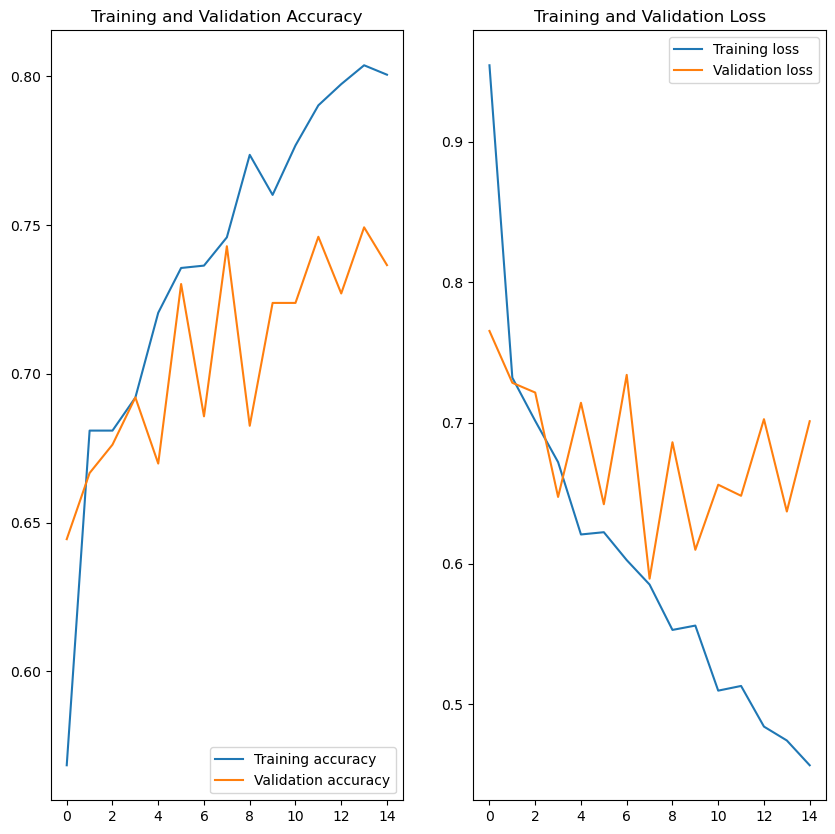

In [24]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [42]:
# predict on new data
img = tf.keras.utils.load_img(
    "breast-cancer-data/test_3.png", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

FileNotFoundError: [Errno 2] No such file or directory: 'breast-cancer-data/test_3.png'

In [26]:
# # convert the model to tensorflow lite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # save the model
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)

In [27]:
# # run the tensorflow lite model
# TF_MODEL_FILE_PATH = 'model.tflite'
# interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [28]:
# # print the signature of the converted model to get names of the inputs and outputs
# interpreter.get_signature_list()

In [29]:
# # test the loaded model
# classify_lite = interpreter.get_signature_runner('serving_default')
# classify_lite

In [30]:
# # make predictions using tensorflow lite model
# predictions_lite = classify_lite(sequential_1_input=img_array)["outputs"]
# score_lite = tf.nn.softmax(predictions_lite)

In [31]:
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
# )

In [32]:
import os
import json
import tempfile
import requests

In [33]:
MODEL_DIR = "ML/models/breast_cancer_model"
version = '1'
export_path = os.path.join(MODEL_DIR, str(version))

# save the model
model.save(export_path, save_format='tf')
print('\nexport_path = {}'.format(export_path))
!dir {export_path}

INFO:tensorflow:Assets written to: ML/models/breast_cancer_model\1\assets


INFO:tensorflow:Assets written to: ML/models/breast_cancer_model\1\assets



export_path = ML/models/breast_cancer_model\1


Invalid switch - "models".


In [34]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['sequential_1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 180, 180, 3)
        name: serving_default_sequential_1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['outputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
The MetaGraph with tag set ['serve'] contains the following ops: {'Relu', 'Const', 'Conv2D', 'Placeholder', 